In [1]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image
import cv2
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
import pathlib
import torch.nn as nn
from tqdm import trange, tqdm
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision import models

import sys
sys.path.append('/gpfs01/berens/user/iilanchezian/Projects/ARAM/')
from utils.run_file_helpers import evaldirs_dict, data_loader_dict, parser_add_commons, parser_add_config, models_dict
from utils.load_trained_model import load_model
import utils.datasets as dl
from utils.model_normalization import EyepacsWrapper_clahe_good_qual
from utils.models.models_32x32.resnet import ResNet18, ResNet34, ResNet50
from utils.models.models_32x32.wide_resnet import WideResNet28x10, WideResNet34x20
from utils.models.models_32x32.wideresnet_carmon import WideResNet as WideResNetCarmon
from utils.models.models_32x32.fixup_resnet import fixup_resnet56
from utils.models.models_32x32.shake_pyramidnet import ShakePyramidNet
from utils.models.model_factory_32 import build_model as build_model32
from utils.models.model_factory_224 import build_model as build_model224
from utils.models.models_224x224.resnet_224 import resnet50 as imagenet_resnet50


cannot import name 'zero_gradients' from 'torch.autograd.gradcheck' (/gpfs01/berens/user/iilanchezian/.local/lib/python3.7/site-packages/torch/autograd/gradcheck.py)


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def get_feats_and_labels(dataset, split, bs=4):
    if dataset == 'eyepacs':
        params_dict = {**dict.fromkeys(['eyepacs'],
                  {'split': split, 'batch_size': bs, 'augm_type': 'none', 'size': img_size,
                   'preprocess': None, 'bg_kernel': None, 'clahe': False,
                   'balanced': False, 'binary': True, 'data_folder': data_folder,
                   'project_folder': project_folder, 'shuffle': False}),
                  }
    elif dataset == 'dm_samples':
        params_dict = {**dict.fromkeys(['dm_samples'],
                  {'split': split, 'batch_size': bs, 'augm_type': 'none', 'size': img_size,
                   'preprocess': None, 'bg_kernel': None, 'clahe': False,
                   'data_folder': data_folder, 'filenames':filenames, 'project_folder': project_folder, 
                   'shuffle': False}),
                  }
    else:
        raise NotImplementedError
    loader = data_loader_dict[dataset](**params_dict[dataset])
    
    model = imagenet_resnet50(pretrained=False, num_classes=2)

    state_dict_file = f'/gpfs01/berens/user/iilanchezian/Projects/AdversarialConsistentScoreMatching-' + \
                      f'Counterfactuals/fundusKaggleModels/ResNet50/' + \
                      f'model_2022-02-17 19:20:10.720997 funduskaggle lr=0.00100 superconverge_small ' + \
                      f'ep=3 attack=None fts=Max seed=0 at=L2 eps=0.01 iter=10/ep_3.pth'
    state_dict = torch.load(state_dict_file, map_location=device)
    model.load_state_dict(state_dict)
    model = EyepacsWrapper_clahe_good_qual(model)
    model.eval()
    model.to(device)
    
    features = []
    y = np.array([])

    for inputs, labels in tqdm(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
#         print(labels)

        with torch.set_grad_enabled(False): 
            outputs_batch, feats_batch = model(inputs, with_latent=True)
            features.append(feats_batch)
#             if len(features) == 0:
#                 features = feats.cpu().numpy()
#             else:
#                 features = np.vstack((features, feats.cpu().numpy()))
            y = np.append(y, labels.cpu().numpy())

    features_tensor = torch.vstack(features)
    print(features_tensor.shape)
    print(y.shape)
    del model
    return features_tensor, y 

In [4]:
dataset = 'eyepacs'
data_folder = '/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/'
project_folder = '/gpfs01/berens/user/iilanchezian/Projects/ARAM'
eval_dir = evaldirs_dict[dataset]
class_labels = [0,1]
num_classes = len(class_labels)
img_size=(224,224)

feats_eyepacs, y_eyepacs = get_feats_and_labels(dataset='eyepacs', split='train', bs=16)

train 16 False (224, 224) 2 True none False False
clahe False None
csv file qual_eval_train.csv
labels_type is onset2


100% 2933/2933 [09:06<00:00,  5.36it/s]

torch.Size([46921, 2048])
(46921,)


In [5]:
dataset = 'dm_samples'
data_folder = '/gpfs01/berens/user/iilanchezian/Projects/guided-diffusion/no_rotate_4_class_balancing_trainv2/'
project_folder = '/gpfs01/berens/user/iilanchezian/Projects/ARAM'
eval_dir = evaldirs_dict[dataset]
# filenames = ['103.png', '43.png', '361.png', '528.png', '568.png', '894.png']
# filenames = ['4.png', '14.png', '23.png', '29.png', '34.png', '37.png','48.png', '49.png',
#              '53.png', '60.png', '64.png', '68.png', '70.png', '71.png', '96.png', '97.png',
#              '100.png', '151.png', '196.png', '238.png', '240.png', '259.png', '315.png', '324.png', 
#              '346.png', '348.png', '362.png', '422.png', '493.png', '534.png', '578.png', '702.png',
#              '731.png', '752.png', '775.png', '874.png', '934.png', '961.png', ]

filenames = ['535.png']

# class_labels = [0,1]
# num_classes = len(class_labels)
img_size=(224,224)

feats_samples, _ = get_feats_and_labels(dataset='dm_samples', split='test', bs=1)

1 False (224, 224) 2 none
clahe False None


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

torch.Size([1, 2048])
(1,)


In [6]:
def get_feature_dists(features_eyepacs, features_samples):
    all_dists = [] 
    for i in np.arange(features_samples.shape[0]):
        diffs_sample = features_eyepacs - features_samples[i,:]
        dists = torch.norm(diffs_sample, dim=1, p=2.0)
        all_dists.append(dists)
        
    dists_stacked = torch.vstack(all_dists)
    dists_stacked = dists_stacked.cpu().numpy()
    return dists_stacked 

In [7]:
def get_feature_dists_2(features_eyepacs, features_samples):
    features_eyepacs = torch.unsqueeze(features_eyepacs, dim=0)
    features_samples = torch.unsqueeze(features_samples, dim=0)
    
    dists = torch.cdist(features_samples, features_eyepacs)
    dists_final = dists[0].cpu().numpy()
    return dists_final

In [8]:
dists_1 = get_feature_dists(feats_eyepacs, feats_samples)

In [9]:
dists_2 = get_feature_dists_2(feats_eyepacs, feats_samples)

In [10]:
print(dists_1.shape)
print(dists_1[4,0])

(1, 46921)


IndexError: index 4 is out of bounds for axis 0 with size 1

In [ ]:
print(dists_2.shape)
print(dists_2[4,0])

In [11]:
data_dir = '/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/images/'
csv_file = '/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/metadata/splits_longitudinal_test/qual_eval_train.csv'
gen_dir = '/gpfs01/berens/user/iilanchezian/Projects/guided-diffusion/' \
          'no_rotate_4_class_balancing_trainv2/'

In [12]:
df = pd.read_csv(csv_file, low_memory=False)
print(f'Initial shape: {df.shape}')
good_qual_desc = ['Good', 'Excellent']
df = df[df['session_image_quality'].isin(good_qual_desc)]
df =df[~df['diagnosis_image_dr_level'].isna()]
print(f'Shape after filtering: {df.shape}')

Initial shape: (46921, 55)
Shape after filtering: (46921, 55)


In [13]:
all_files = df['image_path']
all_files = all_files.apply(lambda x: data_dir + x)
all_files = all_files.tolist()

In [14]:
def get_sample_image(gen_img_file):
    with Image.open(gen_img_file) as sample_img:
        sample_img = np.asarray(sample_img).astype(np.float64)
    #     sample_img_vec = sample_img.flatten()
    #     sample_img_vec = np.tile(sample_img_vec, (batch_size,1))
    #     sample_repeated = torch.tensor(sample_img_vec)
        sample_img_tensor = torch.tensor(sample_img)
        print(sample_img_tensor.shape)
        sample_img_tensor = sample_img_tensor.permute(2, 0, 1)
        print(sample_img_tensor.shape)
        sample_img_tensor = sample_img_tensor.unsqueeze(0)
    return sample_img_tensor

In [15]:
def get_neighbors(dists):
    sorted_index = np.argsort(dists)
    k = 50
    neighbors = [] 
    for j in sorted_index[:k]:
        print(all_files[j])
        print(dists[j])
        neighbors.append(all_files[j])
    return neighbors 

In [16]:
def plot_neighbors(gen_img_file, neighbors, save_filename):
    fig, axes = plt.subplots(1, len(neighbors), figsize=(25,4))
    fig.suptitle('Nearest neighbors')

    with Image.open(gen_img_file) as sample_img:
        sample_img = np.asarray(sample_img)
        axes[0].imshow(sample_img)
        axes[0].set_xticks([])
        axes[0].set_yticks([])
    for i,ax in enumerate(axes[1:]):
        with Image.open(neighbors[i]) as img:
            img = np.asarray(img)
            img = cv2.resize(img, (256,256))
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_filename, dpi=300)

/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/images/images-set-3_balance/1065598_11539512_Left Field 1.png
0.30921304
/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/images/images-set-3/1107903_11875371_Right Field 1.png
0.30953345
/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/images/images-set-3_balance/1045834_11379648_Left Field 1.png
0.32226312
/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/images/images-set-3_balance/1072291_11593273_Left Field 1.png
0.3273173
/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/images/images-set-1/1314222_13453565_Right Field 1.png
0.3331295
/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/images/images-set-3/1124573_12009042_Right Field 1.png
0.33387515
/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/images/images-set-1_balance/1230330_12827772_Left Field 1.png
0.33606115
/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/images/images-se

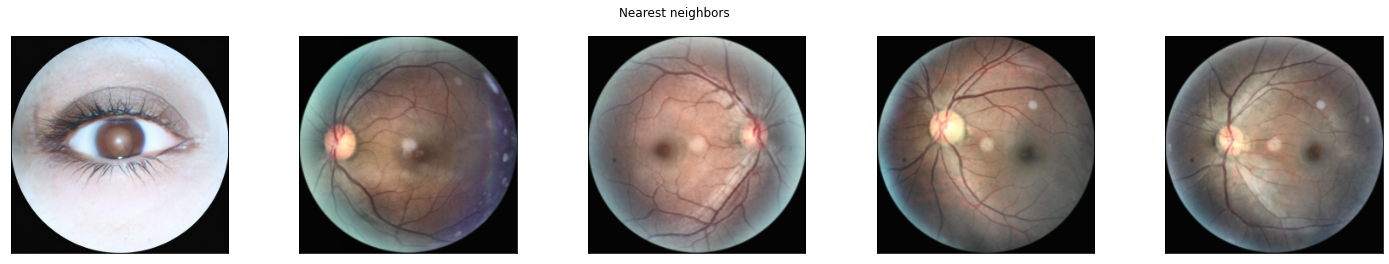

In [17]:
for i in np.arange(len(filenames)):
    neighbors = get_neighbors(dists_2[i,:])
    file_num = filenames[i].split('.')[0]
    plot_neighbors(os.path.join(gen_dir, filenames[i]), neighbors[:5], f'feature_spaces_NNs_{file_num}.png')

In [5]:
import openTSNE

In [6]:
%%time
aff50 = openTSNE.affinity.PerplexityBasedNN(
    feats_eyepacs,
    perplexity=50,
    n_jobs=32,
    random_state=0,
)

CPU times: user 26min 17s, sys: 6min 27s, total: 32min 44s
Wall time: 21min 2s


In [7]:
x = feats_eyepacs.cpu().numpy()
init = openTSNE.initialization.rescale(x[:, :2])

In [8]:
%%time
embedding_standard = openTSNE.TSNE(
    n_jobs=32,
    verbose=True,
).fit(affinities=aff50, initialization=init)

--------------------------------------------------------------------------------
TSNE(n_jobs=32, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=3910.08 for 250 iterations...
Iteration   50, KL divergence 5.6921, 50 iterations in 3.5620 sec
Iteration  100, KL divergence 5.0088, 50 iterations in 3.5923 sec
Iteration  150, KL divergence 4.8473, 50 iterations in 3.5323 sec
Iteration  200, KL divergence 4.7753, 50 iterations in 3.5200 sec
Iteration  250, KL divergence 4.7400, 50 iterations in 3.5747 sec
   --> Time elapsed: 17.78 seconds
===> Running optimization with exaggeration=1.00, lr=3910.08 for 500 iterations...
Iteration   50, KL divergence 3.4476, 50 iterations in 3.5547 sec
Iteration  100, KL divergence 3.0015, 50 iterations in 3.6037 sec
Iteration  150, KL divergence 2.7727, 50 iterations in 4.0972 sec
Iteration  200, KL divergence 2.6307, 50 iterations in 5.0223 sec
Iteration  2

In [9]:
import matplotlib

def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):

    if ax is None:
        _, ax = matplotlib.pyplot.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

In [10]:
MACOSKO_COLORS = {
    0: "#A5C93D",
    1: "#8B006B",
    2: "#2000D7",
    3: "#538CBA",
    4: "#8B006B",
    5: "#B33B19",
    6: "#8B006B",
    7: "#8B006B",
    8: "#8B006B",
    9: "#C38A1F",
    10: "#538CBA",
    11: "#8B006B",
}

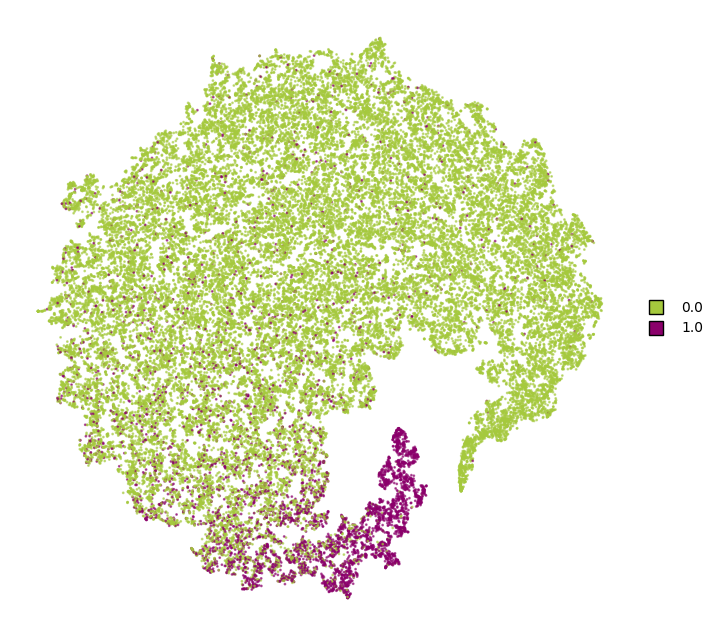

In [11]:
plot(embedding_standard, y_eyepacs, colors=MACOSKO_COLORS)